# Load Libraries

In [1]:
# packages
import os
import h5py
import time
import random
import itertools
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker
import pandas as pd
import numpy as np
from time import gmtime, strftime
import random
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.models import model_from_json
from sklearn.utils import shuffle
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.decomposition import PCA
# import tensorflow_addons as tfa

# EVALUATION modules
from scipy.stats import spearmanr

params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)


2023-11-23 18:06:24.830626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 18:06:24.962929: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 18:06:25.353612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64
2023-11-23 18:06:25.353652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

# Helper Functions

## Preprocessing

In [2]:
def split_sequences(input_data, sequence_length, stride = 1, option = None):
    """
     
    """
    X = list()
    
    for i in range(0,len(input_data),stride):
        # find the end of this pattern
        end_ix = i + sequence_length
        
        # check if we are beyond the dataset
        if end_ix > len(input_data):
            break
        
        # gather input and output parts of the pattern
        if option=='last':
            seq_x = input_data[end_ix-1, :]
        elif option=='next':
            seq_x = input_data[end_ix, :]
        else:
            seq_x = input_data[i:end_ix, :]
        X.append(seq_x)
    
    return np.array(X)


## Plots

In [3]:
def plot_sensor_signal(x_real,x_pred,var_names,num=1000,figsize=20):
    input_dim = len(var_names)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))   
    
    ax = fig.add_subplot(gs[0])
    ax.scatter(np.arange(0,num),x_real[-num:,0],label="True",marker='.')
    ax.scatter(np.arange(0,num),x_pred[-num:,0],label="Pred",marker='.')
    plt.title("RUL Estimation")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
def printEstimatedRUL(df, unit, labels):
    df = df[df['unit']==unit].groupby(['unit','cycle'])
    df = df.mean()
    plt.figure()
    plt.plot(np.array(df[labels[0]].values, dtype=np.float16),'g-',label='ground truth')
    plt.plot(np.array(df[labels[1]].values, dtype=np.float16),'b-',label='RUL Estimated')
    plt.legend(['ground truth','estimated'])
    plt.xlabel('Cycle')
    plt.ylabel('RUL')
    plt.title('Unit:'+ str(unit))
    plt.show()
    
def plot_df_color_per_unit(data, variables, labels, color_dic_unit, size=7, labelsize=17, option='Time', name=None, theta=False):
    """
    """
    plt.clf()  
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        if theta:
            ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(".4f"))
            ax.set_ylim(float(data[variables].min()), float(data[variables].max()))
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            if theta:
                ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: round(float(x), 4)))
            else:
                ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

##  Sequence Generator

In [4]:
def sequence_generator(input_data, units, cycles, sequence_length=10,stride = 1, option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        c_mask = cycles[mask]
        x_unit = input_data[mask]
        for j in np.unique(c_mask):
            mask = np.ravel(c_mask==j)
            seq_x_u = split_sequences(x_unit[mask],sequence_length, stride, option)
            X.append(seq_x_u)
            unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
            c_num.extend(np.ones(len(seq_x_u),dtype = int)*j)
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.array(c_num).reshape(-1,1)


def sequence_generator_per_unit(input_data, units, cycles, sequence_length=10, stride =1,option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        x_unit = input_data[mask]
        seq_x_u = split_sequences(x_unit,sequence_length, stride, option)
        X.append(seq_x_u)
        unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
        c_num.append(split_sequences(cycles[mask],sequence_length, stride, option))
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.vstack(c_num)

# Models

# Model construction

## Load Data

In [5]:
# Flight Class FC
FC = 3

In [6]:
# Load data DEV
with h5py.File("FC"+str(FC)+"/FC"+str(FC)+'_dev'+".h5", 'r') as hdf:
            # Development set
            W_train = np.array(hdf.get('W_dev'), dtype='float16')             # W
            X_s_train = np.array(hdf.get('X_s_dev'), dtype='float16')         # X_s
            X_v_train = np.array(hdf.get('X_v_dev'), dtype='float16')         # X_v
            T_train = np.array(hdf.get('T_dev'), dtype='float16')             # T
            Y_train = np.array(hdf.get('Y_dev'), dtype='float16')             # RUL  
            A_train = np.array(hdf.get('A_dev'), dtype='float16')
            
            # Varnams
            W_var = np.array(hdf.get('W_var'))
            X_s_var = np.array(hdf.get('X_s_var'))  
            X_v_var = np.array(hdf.get('X_v_var')) 
            T_var = np.array(hdf.get('T_var'))
            A_var = np.array(hdf.get('A_var'))
            
                # from np.array to list dtype U4/U5
            W_var = list(np.array(W_var, dtype='U20'))
            X_s_var = list(np.array(X_s_var, dtype='U20'))  
            X_v_var = list(np.array(X_v_var, dtype='U20')) 
            T_var = list(np.array(T_var, dtype='U20'))
            A_var = list(np.array(A_var, dtype='U20'))
            
# Load data TEST
mode = '_test'
with h5py.File("FC"+str(FC)+"/FC"+str(FC)+'_test'+".h5", 'r') as hdf:
            # Development set
            W_test = np.array(hdf.get('W_test'), dtype='float16')             # W
            X_s_test = np.array(hdf.get('X_s_test'), dtype='float16')         # X_s
            X_v_test = np.array(hdf.get('X_v_test'), dtype='float16')         # X_v
            T_test = np.array(hdf.get('T_test'), dtype='float16')             # T
            Y_test = np.array(hdf.get('Y_test'), dtype='float16')             # RUL  
            A_test = np.array(hdf.get('A_test'), dtype='float16')

units_train=A_train[:,0].reshape(-1,1)
cycles_train=A_train[:,1].reshape(-1,1)
fc_train = A_train[:,2].reshape(-1,1)
hi_train = A_train[:,-1]

units_test=A_test[:,0].reshape(-1,1)
cycles_test=A_test[:,1].reshape(-1,1)
fc_test = A_test[:,2].reshape(-1,1)
hi_test = A_test[:,-1]

print("XS_train",X_s_train.shape)
print(units_train.shape)

XS_train (2854517, 14)
(2854517, 1)


### MaxMin Scale $X_s$ and $W$

In [7]:
# SCALE
# scaler_X = MinMaxScaler(feature_range=(-1,1))
scaler_X = MinMaxScaler()
X_s_train = scaler_X.fit_transform(X_s_train)
X_s_test = scaler_X.transform(X_s_test)

# scaler_W = MinMaxScaler(feature_range=(-1,1))
scaler_W = MinMaxScaler()
W_train = scaler_W.fit_transform(W_train)
W_test = scaler_W.transform(W_test)

scaler_Y = MinMaxScaler(feature_range=(0,1))
Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)

### Downsamplig 0.1Hz

In [8]:
WINDOW_LEN = 50
stride = 1

X_windows_test, U_windows_test,C_windows_test=sequence_generator(X_s_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
W_windows_test,_,_=sequence_generator(W_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
Y_windows_test,_,_=sequence_generator(Y_test,units_test,cycles_test,sequence_length=WINDOW_LEN,option='last',stride = stride)


In [9]:
#X_windows_test, U_windows_test,C_windows_test=sequence_generator_per_unit(X_s_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
#W_windows_test,_,_=sequence_generator_per_unit(W_test,units_test,cycles_test,sequence_length=WINDOW_LEN,stride = stride)
#Y_windows_test,_,_=sequence_generator_per_unit(Y_test,units_test,cycles_test,sequence_length=WINDOW_LEN,option='last',stride = stride)

## RUL MODEL

In [10]:
#model.load_weights("model.h5")

json_file = open("RUL_MODEL/FC"+str(FC)+"/"+"/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
rul_model = model_from_json(loaded_model_json)
rul_model.load_weights("RUL_MODEL/FC"+str(FC)+"/"+"/model.h5")

2023-11-23 18:06:54.476668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-23 18:06:54.480851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-23 18:06:54.481288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-23 18:06:54.481983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Test

In [11]:
rul_predicted = rul_model.predict((X_windows_test,W_windows_test))

2023-11-23 18:07:01.290597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  139/40155 [..............................] - ETA: 44s   

2023-11-23 18:07:02.233381: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40155/40155 [==============================] - 46s 1ms/step


In [12]:
rul_predicted_ = scaler_Y.inverse_transform(rul_predicted)
groud_truth = scaler_Y.inverse_transform(Y_windows_test)

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math 
mae=mean_absolute_error(rul_predicted_,groud_truth)
mse=mean_squared_error(rul_predicted_,groud_truth)
rmse=np.sqrt(mse)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 9.614776
MSE: 133.12907
RMSE: 11.538157


# Plots

## Remaining Useful Life Estimation

In [14]:
df_U_test = DataFrame(data=U_windows_test, columns=['unit']) 
df_Y_test = DataFrame(data=groud_truth, columns=['RUL'])
df_C_test = DataFrame(data=C_windows_test, columns=['cycle']) 
df_Y_hat_test = DataFrame(data=rul_predicted_, columns=['prediction'])
df_test = pd.concat([df_U_test, df_Y_test,df_Y_hat_test, df_C_test], axis=1)

### Flight Class 1

<Figure size 900x600 with 0 Axes>

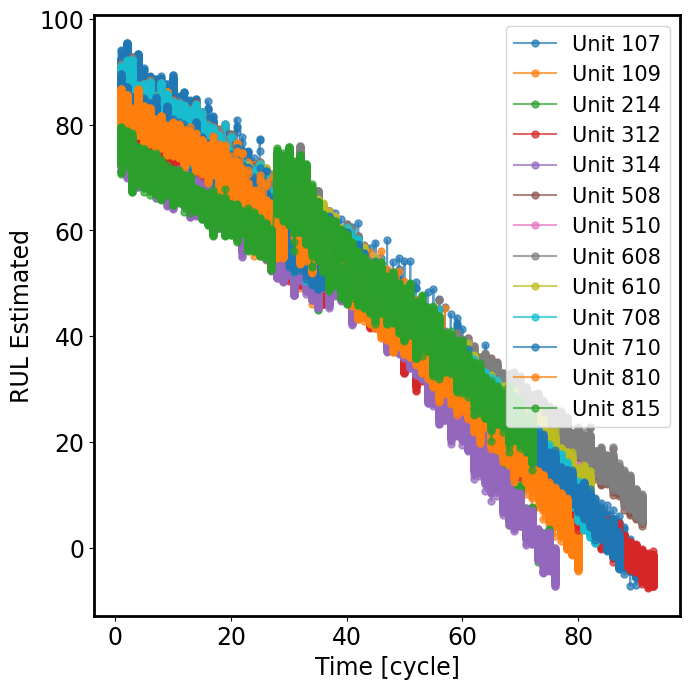

In [19]:
color_dic_unit = {'Unit 107': 'C0', 'Unit 109': 'C1', 'Unit 214': 'C2', 'Unit 312': 'C3', 'Unit 314': 'C4', 'Unit 508': 'C5',
                      'Unit 510': 'C6', 'Unit 608': 'C7', 'Unit 610': 'C8', 'Unit 708': 'C9', 'Unit 710': 'C10',
                      'Unit 810': 'C11', 'Unit 815': 'C12'} 
plot_df_color_per_unit(df_test, ['prediction'], ['RUL Estimated'], color_dic_unit,  option='cycle')

<Figure size 900x600 with 0 Axes>

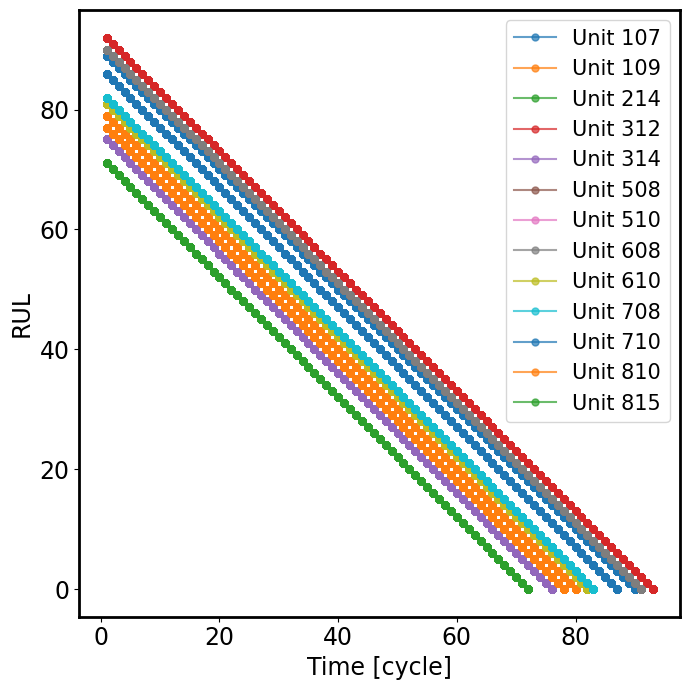

In [20]:
plot_df_color_per_unit(df_test, ['RUL'], ['RUL'], color_dic_unit,  option='cycle')

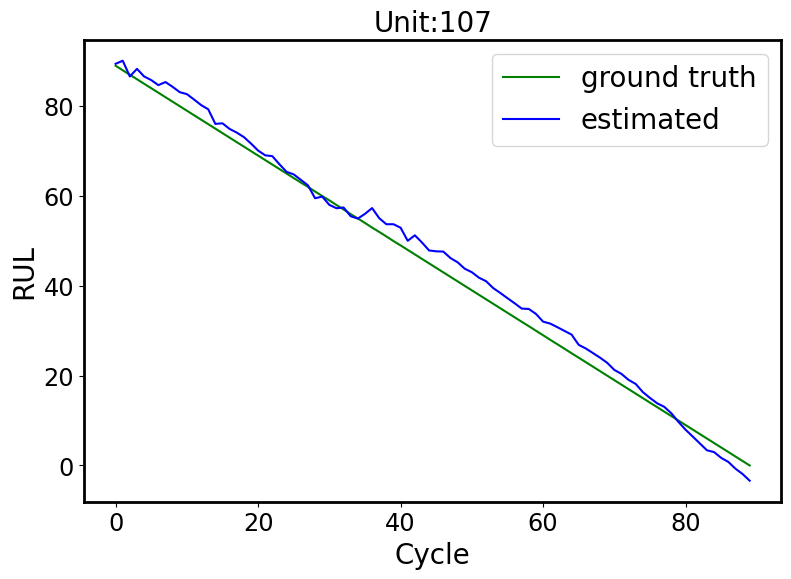

In [21]:
printEstimatedRUL(df_test, 107, ['RUL','prediction'])

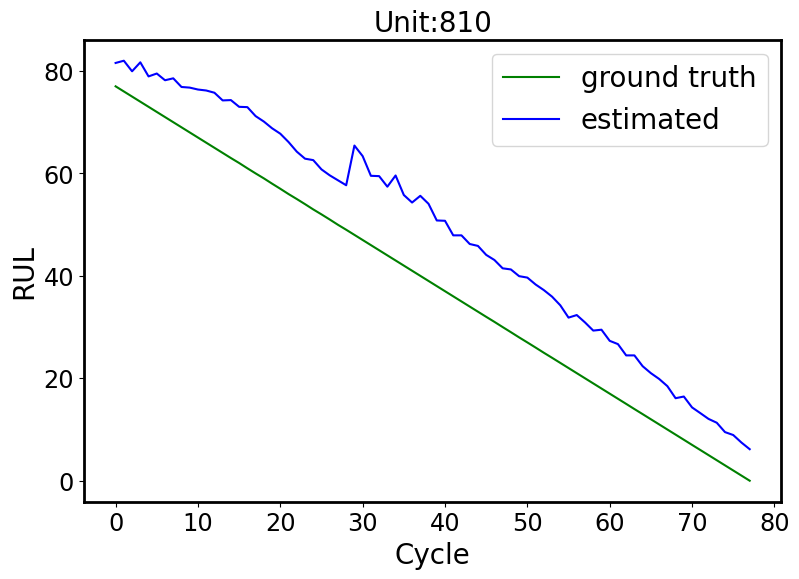

In [22]:
printEstimatedRUL(df_test, 810, ['RUL','prediction'])

#### Plots Degradation per Unit

In [23]:
df_T_test = DataFrame(data=T_test, columns=T_var) 
df_A_test = DataFrame(data=A_test, columns=A_var)
df_test = pd.concat([df_T_test, df_A_test], axis=1)

<Figure size 900x600 with 0 Axes>

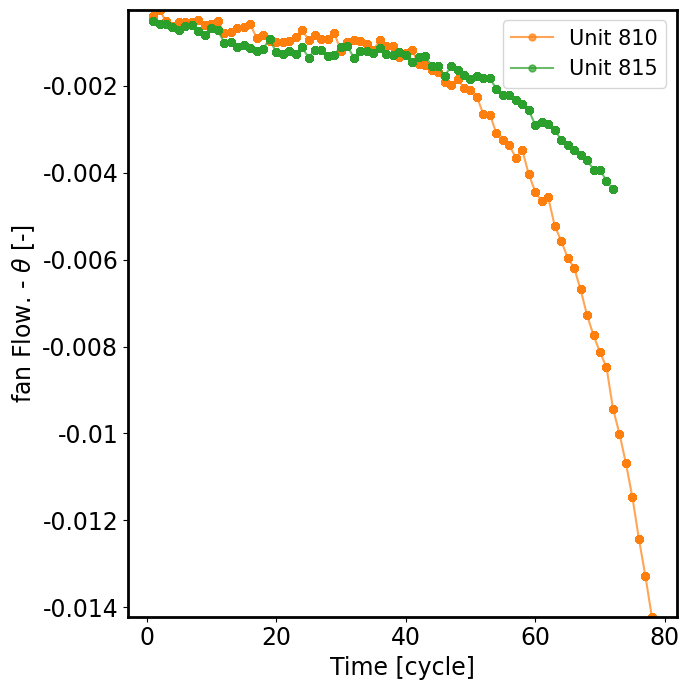

In [24]:
units = [810, 815] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['fan_flow_mod'], [r'fan Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

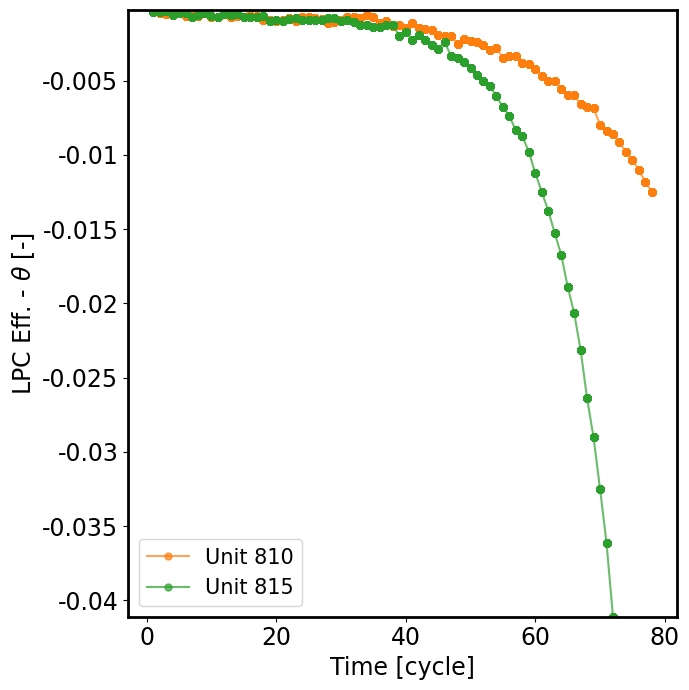

In [111]:
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_eff_mod'], [r'LPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

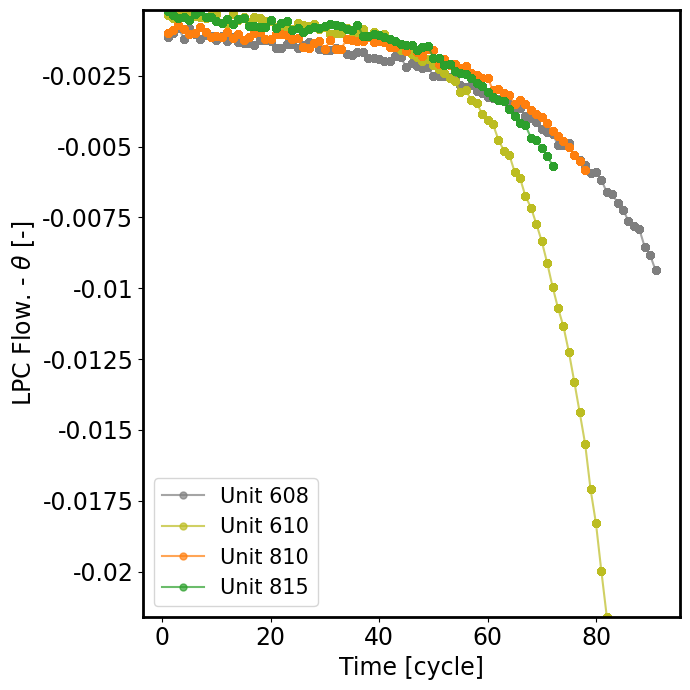

In [113]:
units = [608,610,810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_flow_mod'], [r'LPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

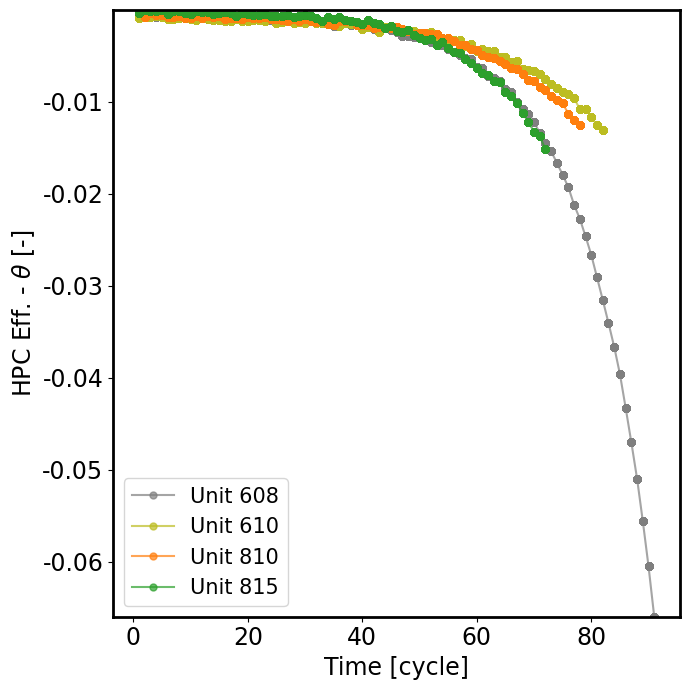

In [114]:
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_eff_mod'], [r'HPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

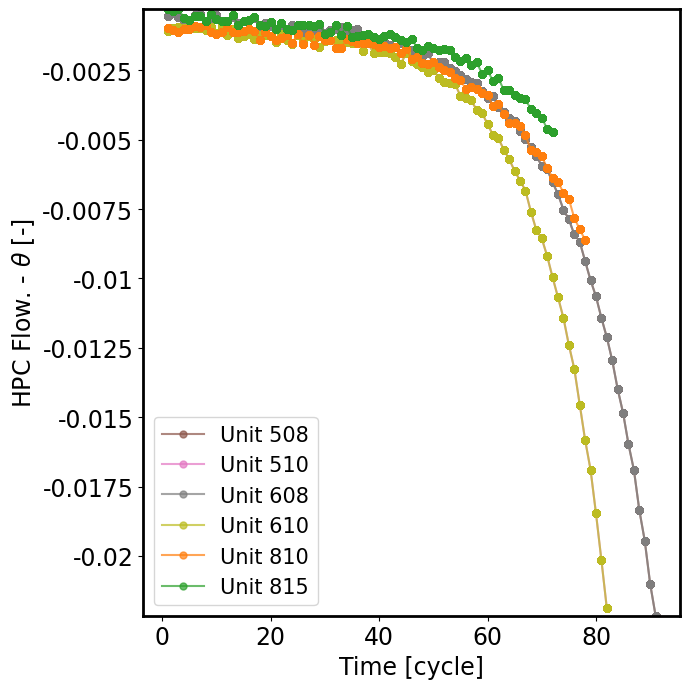

In [115]:
units = [508,510,608,610,810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_flow_mod'], [r'HPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

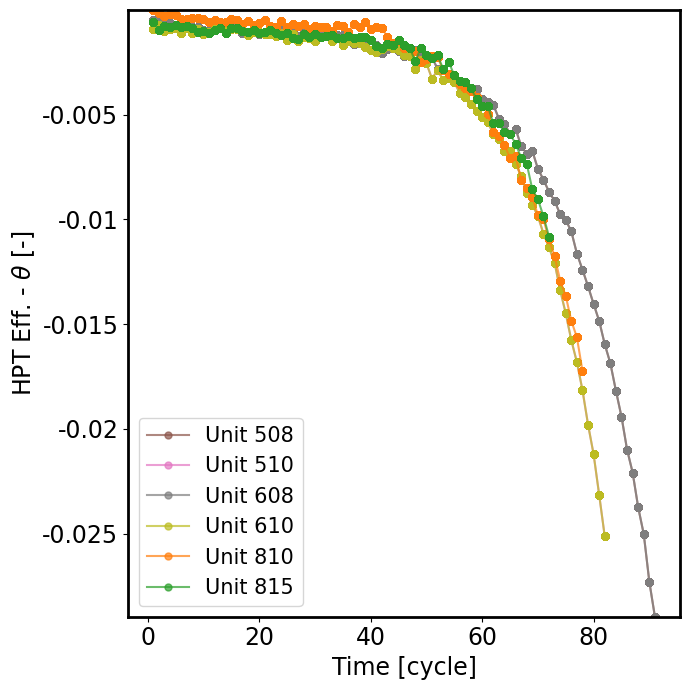

In [116]:
units = [508,510,608,610,810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_eff_mod'], [r'HPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

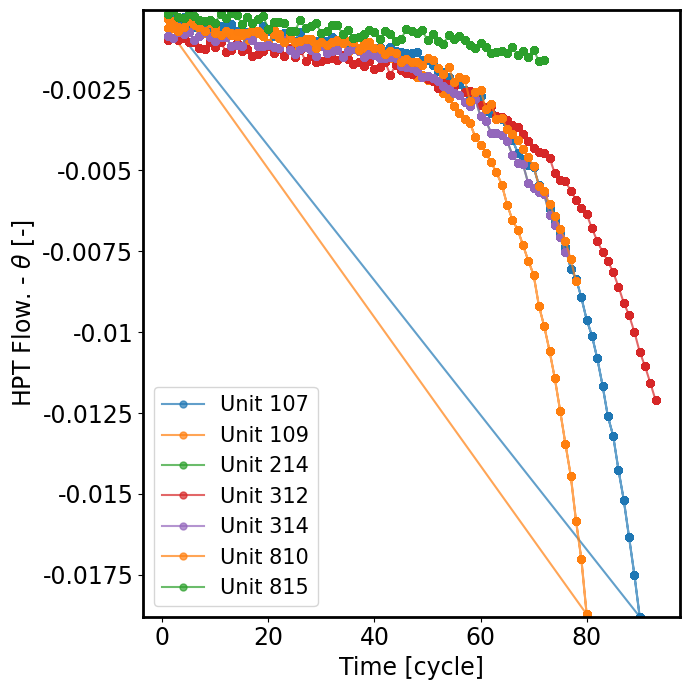

In [117]:
units = [107,109,214,312,314,810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_flow_mod'], [r'HPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

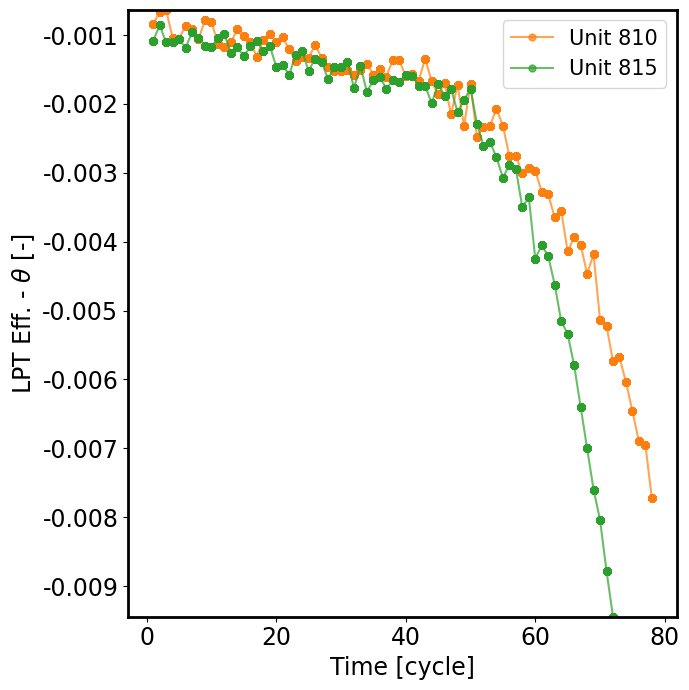

In [118]:
units = [810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_eff_mod'], [r'LPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

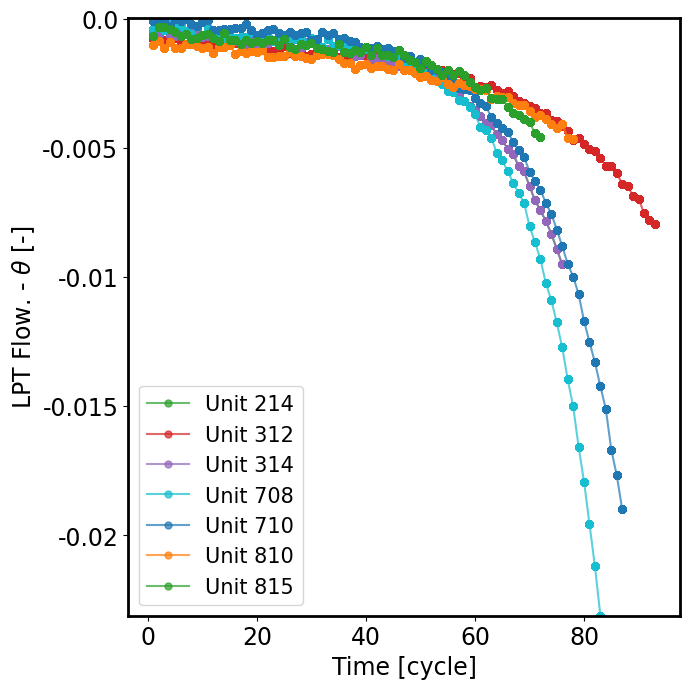

In [119]:
units = [214,312,314,708,710,810,815]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_flow_mod'], [r'LPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

### Flight Class 2

<Figure size 900x600 with 0 Axes>

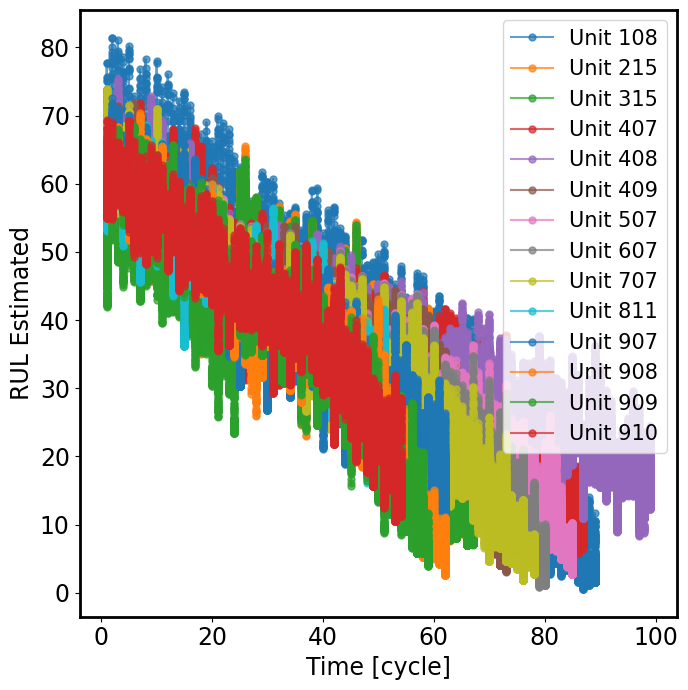

In [15]:
color_dic_unit = {'Unit 108': 'C0', 'Unit 215': 'C1', 'Unit 315': 'C2', 'Unit 407': 'C3', 'Unit 408': 'C4', 'Unit 409': 'C5',
                      'Unit 507': 'C6', 'Unit 607': 'C7', 'Unit 707': 'C8', 'Unit 811': 'C9', 'Unit 907': 'C10',
                      'Unit 908': 'C11', 'Unit 909': 'C12','Unit 910': 'C13'} 
plot_df_color_per_unit(df_test, ['prediction'], ['RUL Estimated'], color_dic_unit,  option='cycle')


<Figure size 900x600 with 0 Axes>

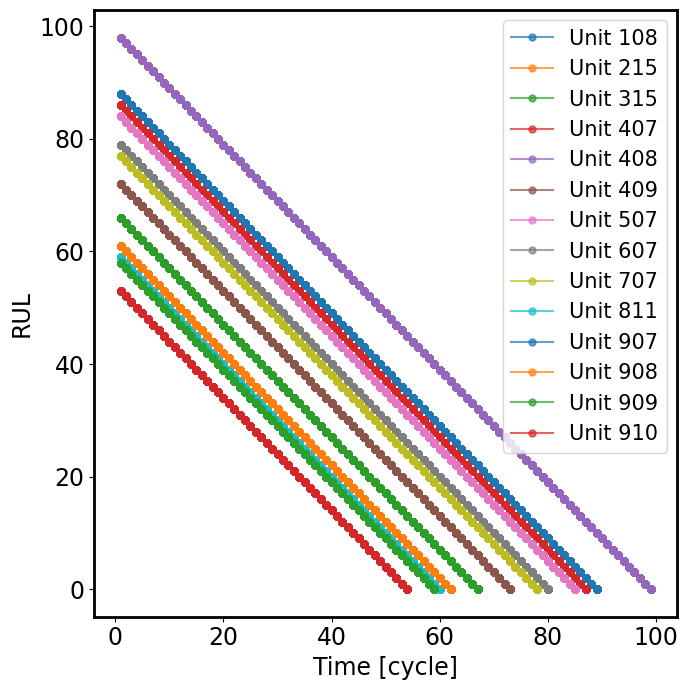

In [16]:
plot_df_color_per_unit(df_test, ['RUL'], ['RUL'], color_dic_unit,  option='cycle')

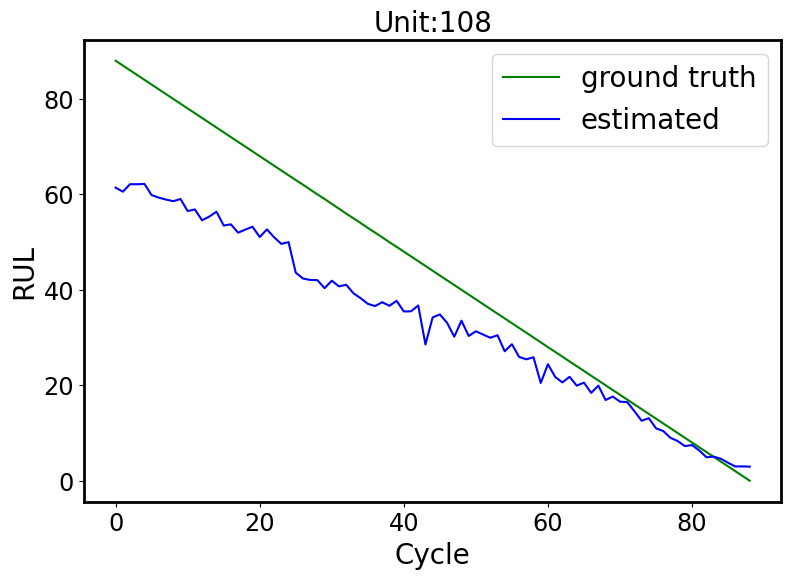

In [32]:
printEstimatedRUL(df_test, 108, ['RUL','prediction'])

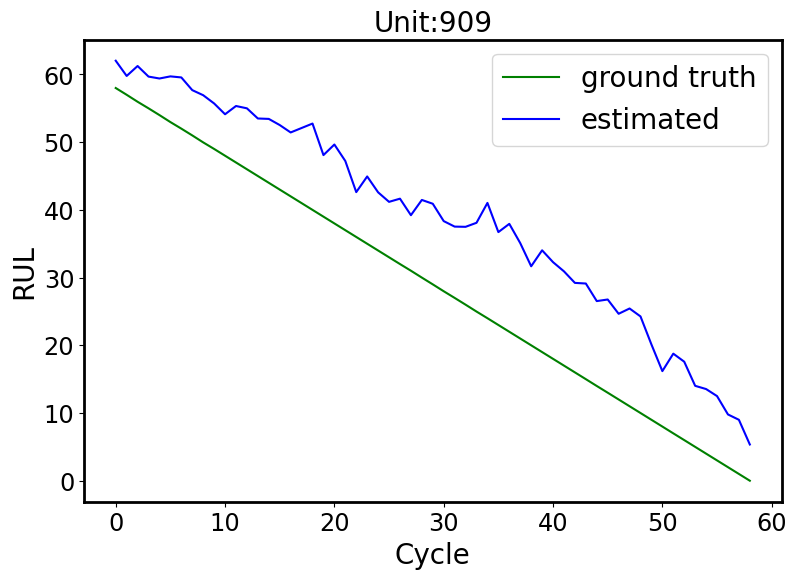

In [33]:
printEstimatedRUL(df_test, 909, ['RUL','prediction'])

#### Plots Degradation per Unit

In [15]:
df_T_test = DataFrame(data=T_test, columns=T_var) 
df_A_test = DataFrame(data=A_test, columns=A_var)
df_test = pd.concat([df_T_test, df_A_test], axis=1)
color_dic_unit = {'Unit 108': 'C0', 'Unit 215': 'C1', 'Unit 315': 'C2', 'Unit 407': 'C3', 'Unit 408': 'C4', 'Unit 409': 'C5',
                      'Unit 507': 'C6', 'Unit 607': 'C7', 'Unit 707': 'C8', 'Unit 811': 'C9', 'Unit 907': 'C10',
                      'Unit 908': 'C11', 'Unit 909': 'C12','Unit 910': 'C13'} 

<Figure size 900x600 with 0 Axes>

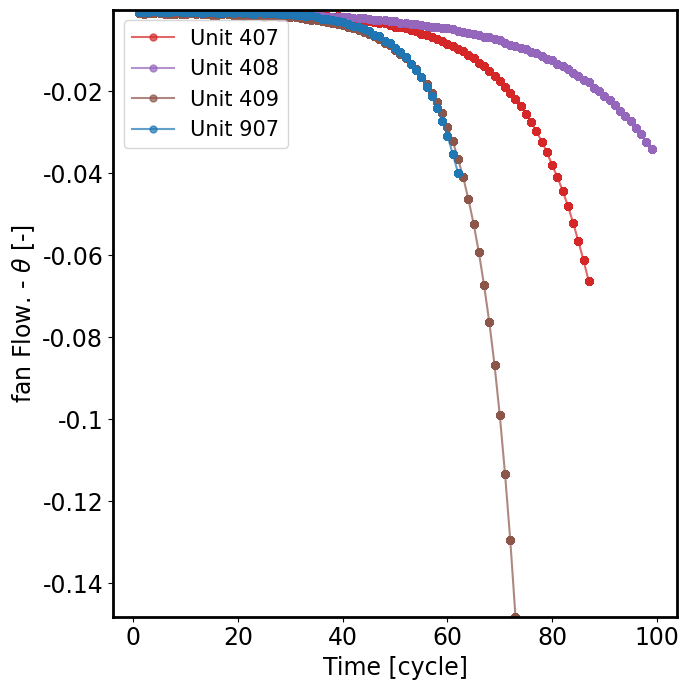

In [17]:
units = [407,408,409,907] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['fan_flow_mod'], [r'fan Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

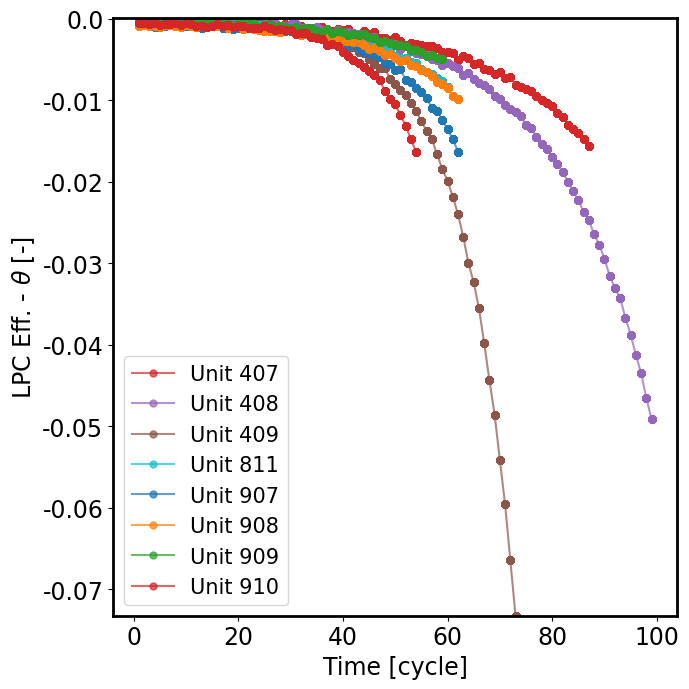

In [19]:
units = [407,408,409,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_eff_mod'], [r'LPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

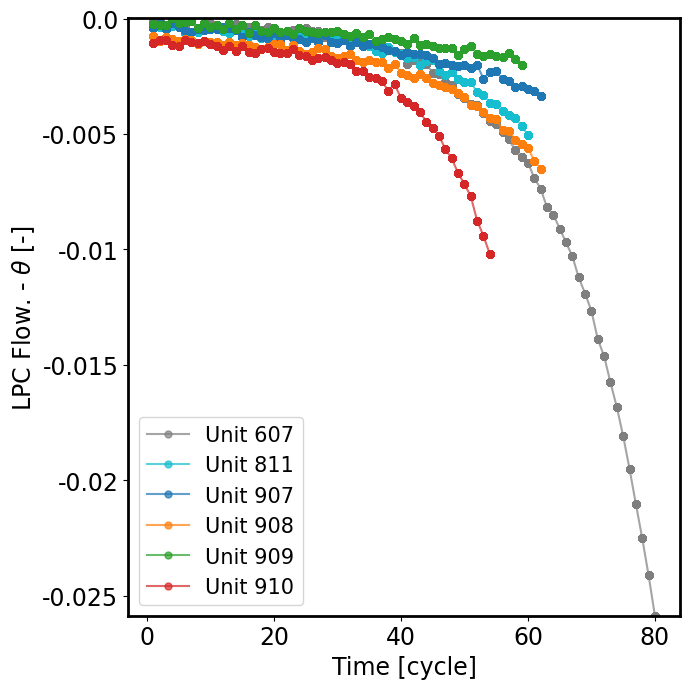

In [20]:
units = [607,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_flow_mod'], [r'LPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

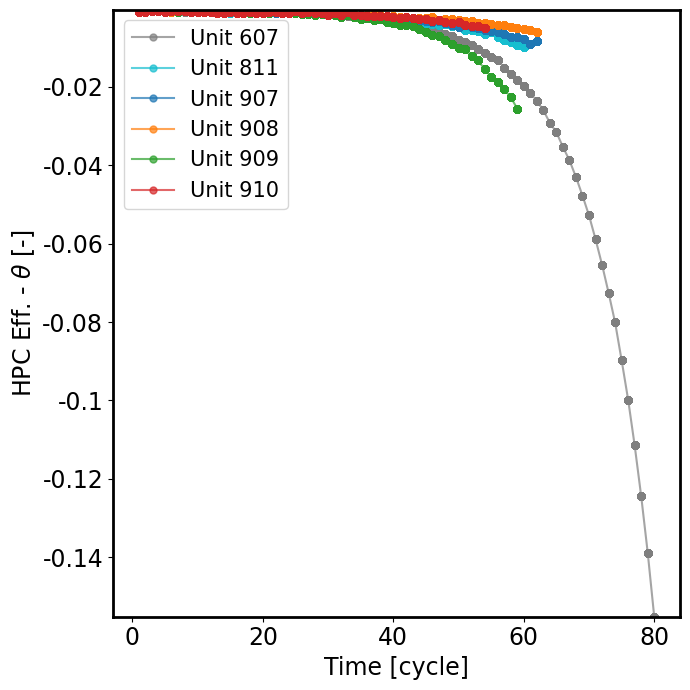

In [21]:
units = [607,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_eff_mod'], [r'HPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

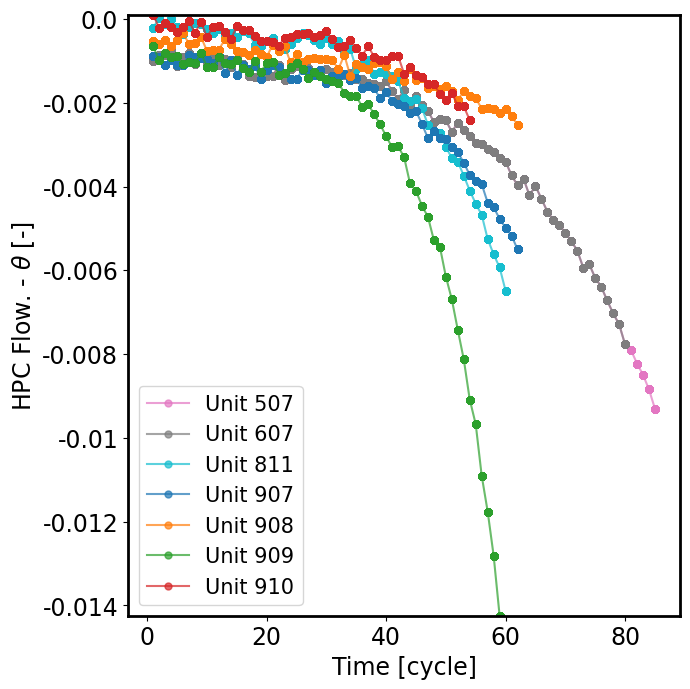

In [22]:
units = [507,607,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_flow_mod'], [r'HPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

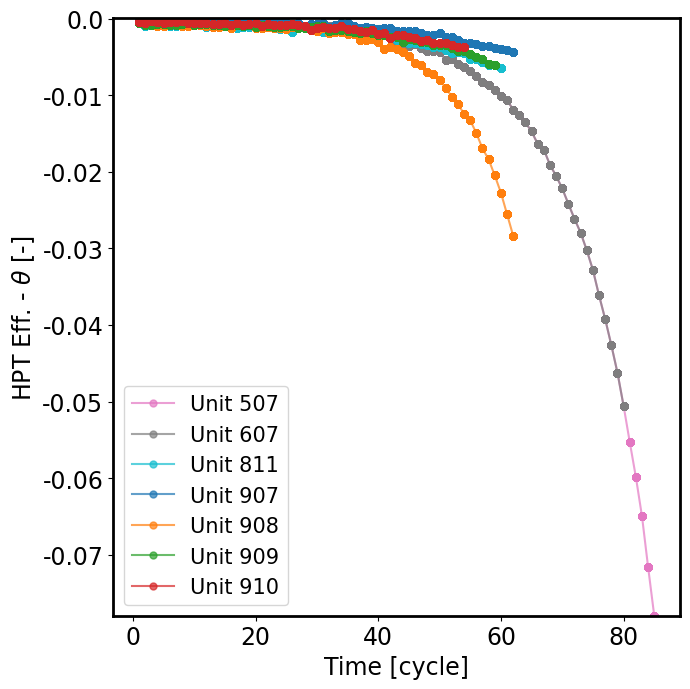

In [23]:
units = [507,607,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_eff_mod'], [r'HPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

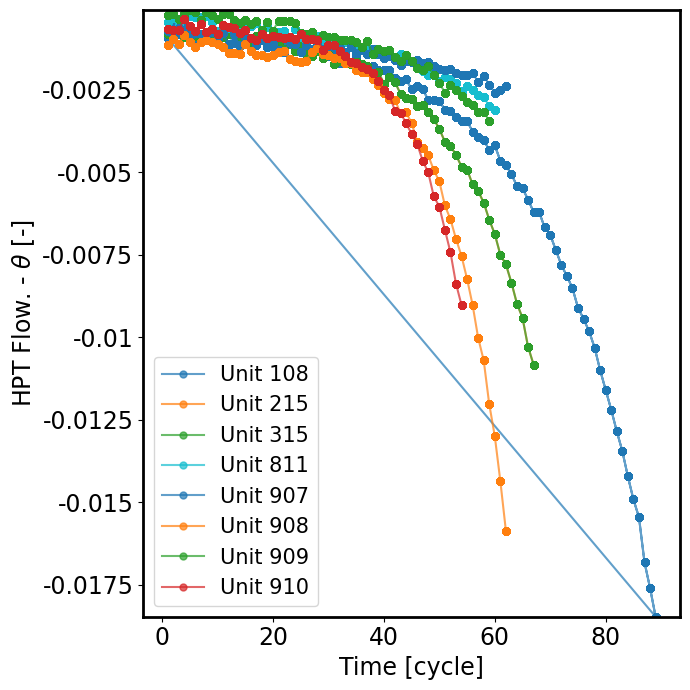

In [24]:
units = [108,215,315,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_flow_mod'], [r'HPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

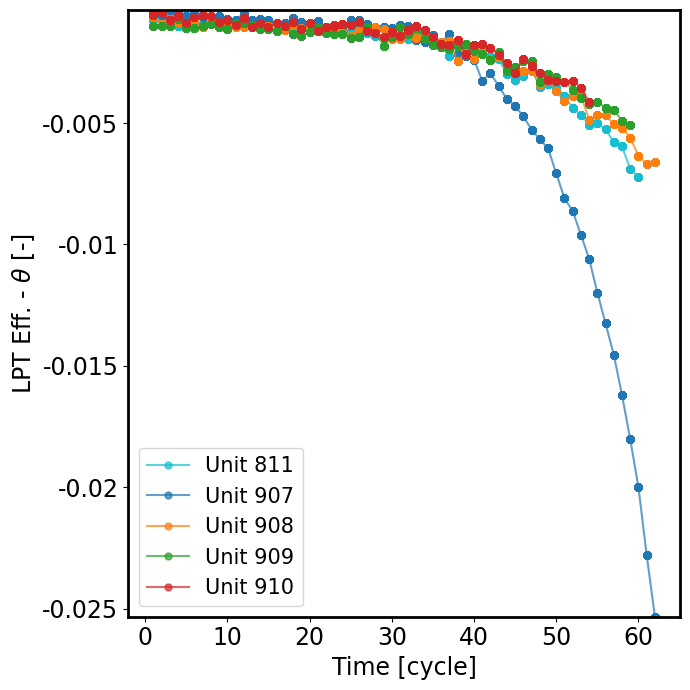

In [25]:
units = [811,907,908,909,910]
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_eff_mod'], [r'LPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

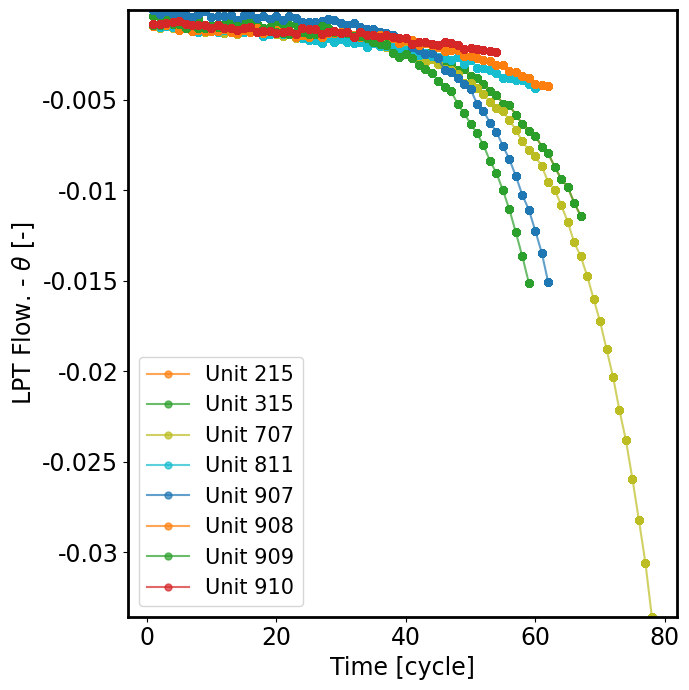

In [26]:
units = [215,315,707,811,907,908,909,910] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_flow_mod'], [r'LPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

### Flight Class 3

<Figure size 900x600 with 0 Axes>

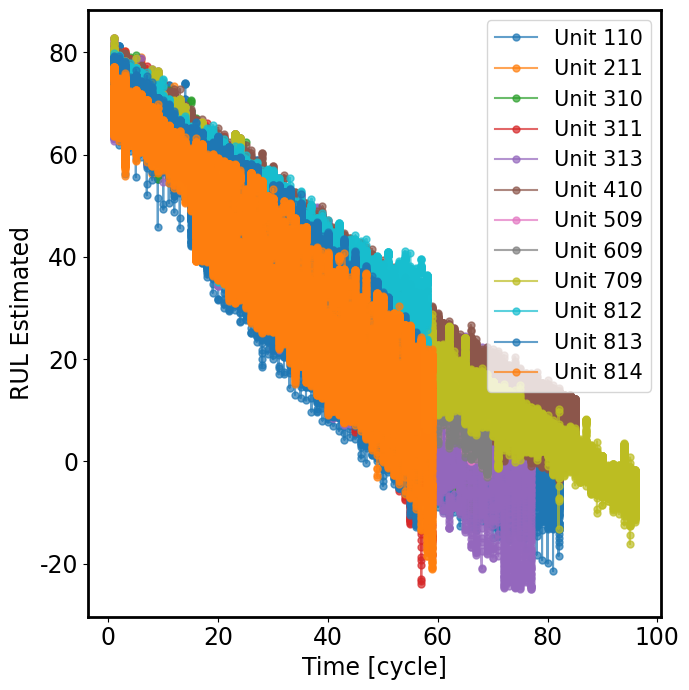

In [15]:
color_dic_unit = {'Unit 110': 'C0', 'Unit 211': 'C1', 'Unit 310': 'C2', 'Unit 311': 'C3', 'Unit 313': 'C4', 'Unit 410': 'C5',
                      'Unit 509': 'C6', 'Unit 609': 'C7', 'Unit 709': 'C8', 'Unit 812': 'C9', 'Unit 813': 'C10',
                      'Unit 814': 'C11'} 
plot_df_color_per_unit(df_test, ['prediction'], ['RUL Estimated'], color_dic_unit,option='cycle')

<Figure size 900x600 with 0 Axes>

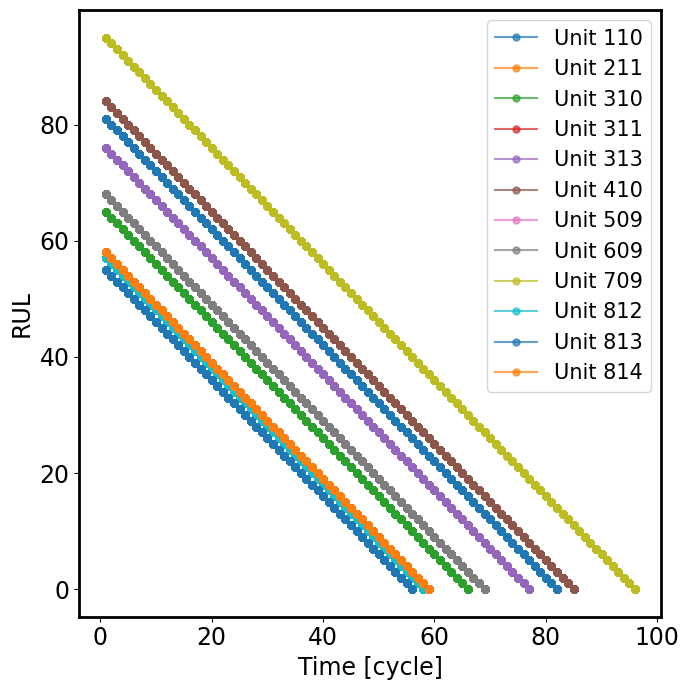

In [16]:
plot_df_color_per_unit(df_test, ['RUL'], ['RUL'], color_dic_unit,option='cycle')

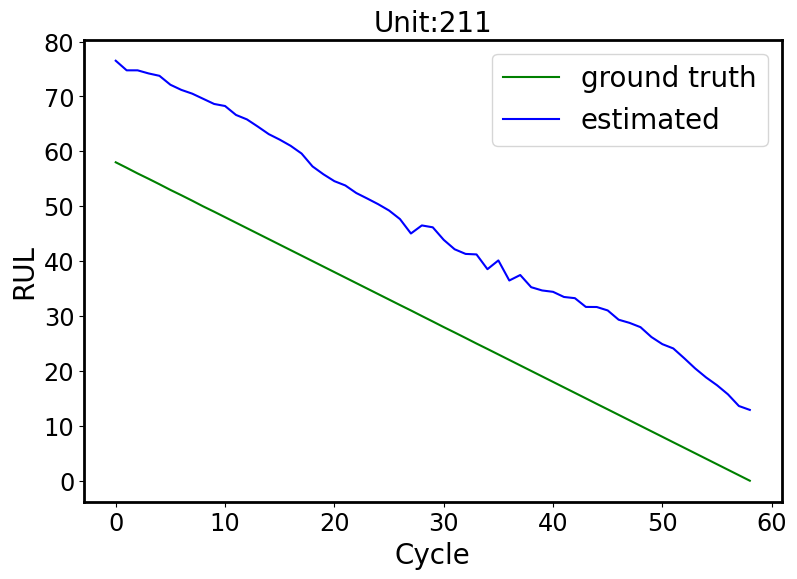

In [17]:
printEstimatedRUL(df_test, 211, ['RUL','prediction'])

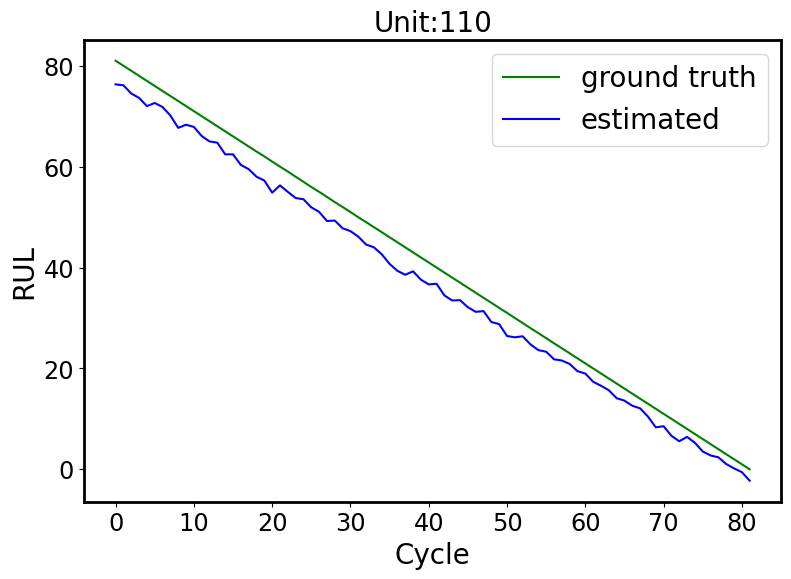

In [18]:
printEstimatedRUL(df_test, 110, ['RUL','prediction'])

#### Plots Degradation per Unit

In [19]:
df_T_test = DataFrame(data=T_test, columns=T_var) 
df_A_test = DataFrame(data=A_test, columns=A_var)
df_test = pd.concat([df_T_test, df_A_test], axis=1)

<Figure size 900x600 with 0 Axes>

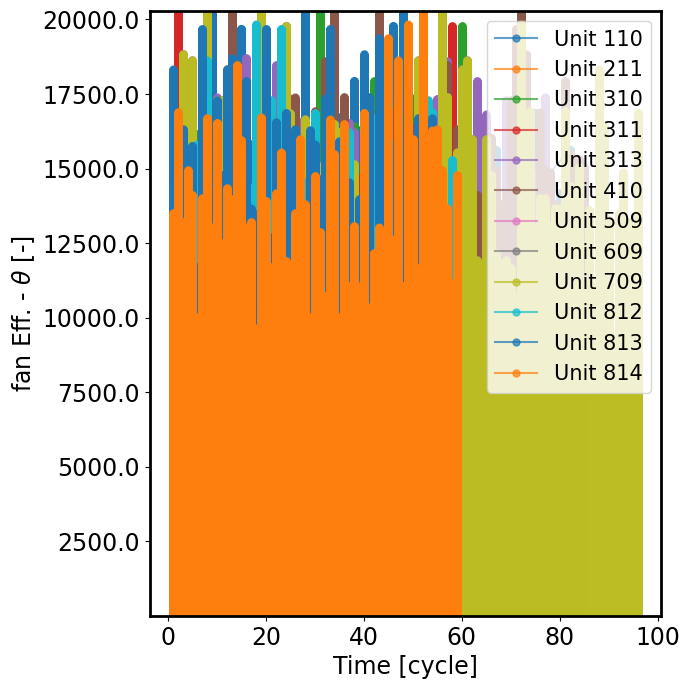

In [20]:
units = [110,211,310,311,313,410,509,609,709,812,813,814] 

plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['fan_eff_mod'], [r'fan Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

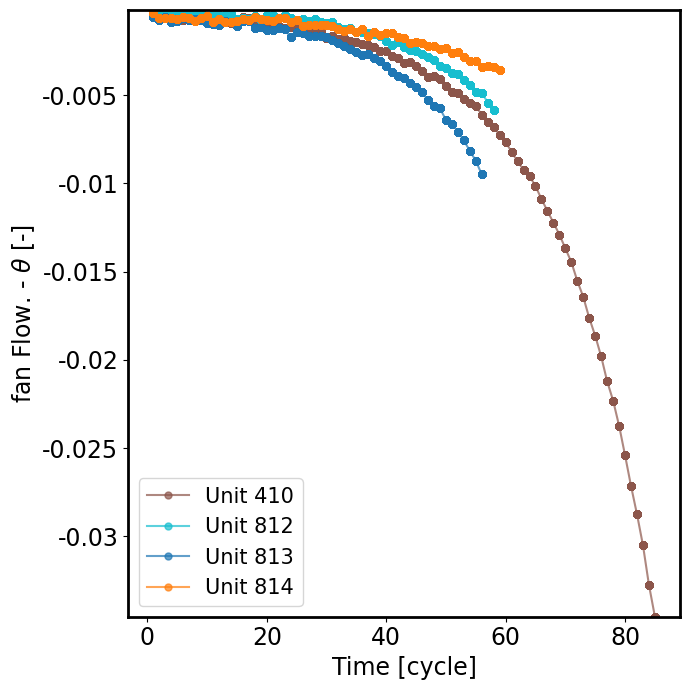

In [21]:
units = [410,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['fan_flow_mod'], [r'fan Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

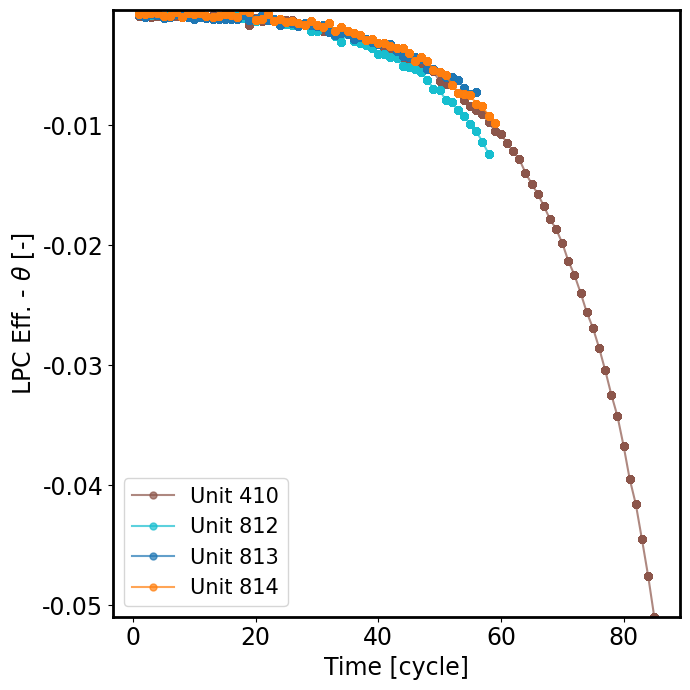

In [22]:
units = [410,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_eff_mod'], [r'LPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

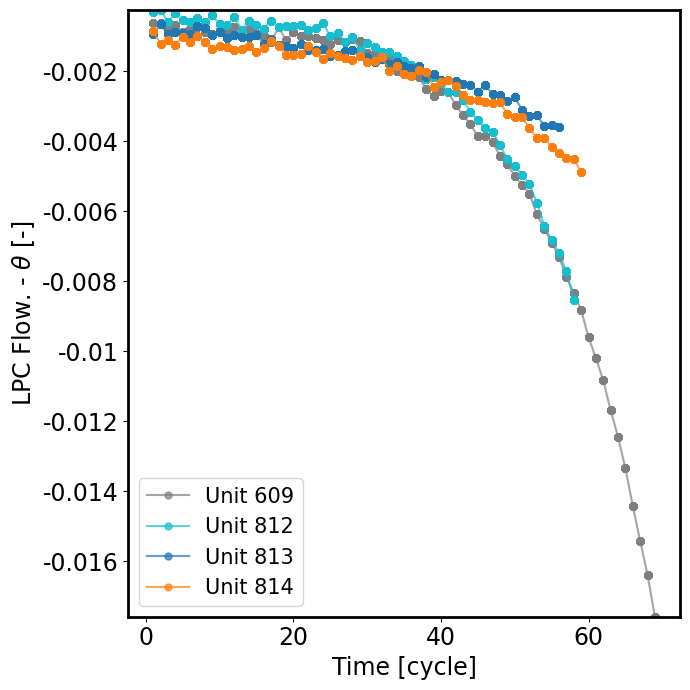

In [23]:
units = [609,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPC_flow_mod'], [r'LPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

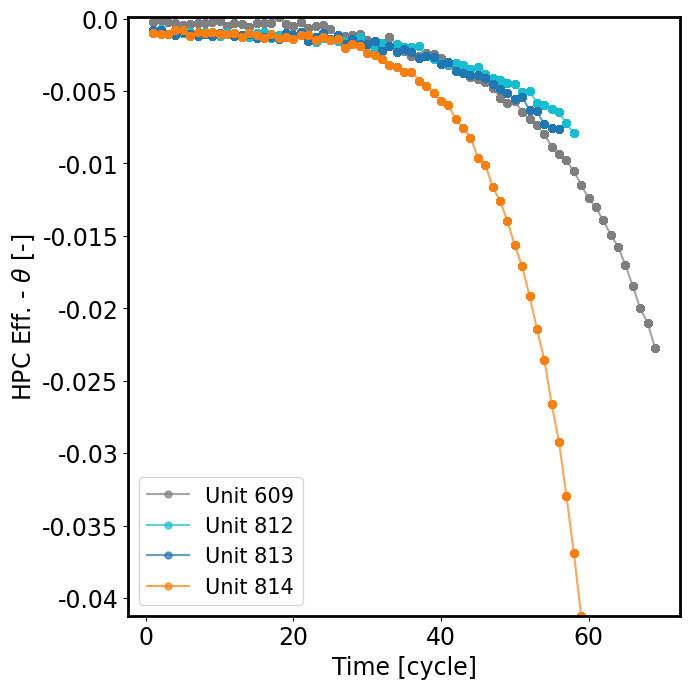

In [24]:
units = [609,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_eff_mod'], [r'HPC Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

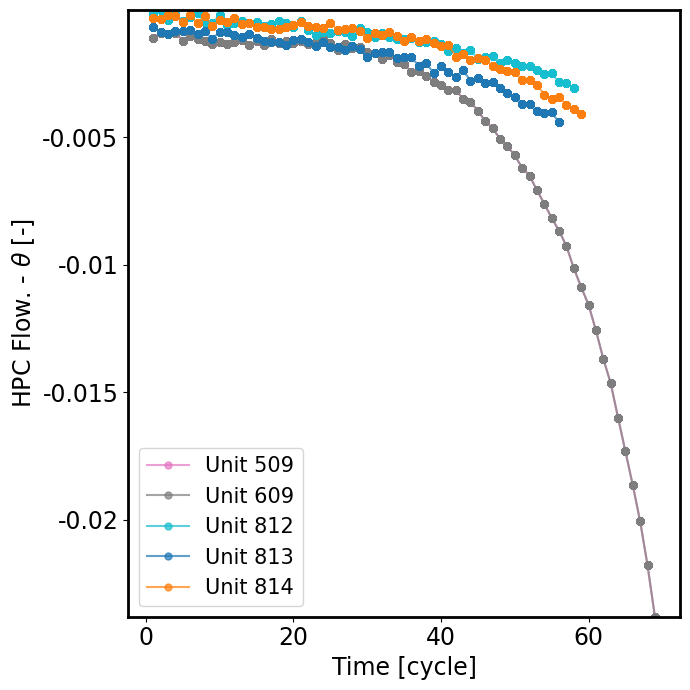

In [27]:
units = [509,609,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPC_flow_mod'], [r'HPC Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

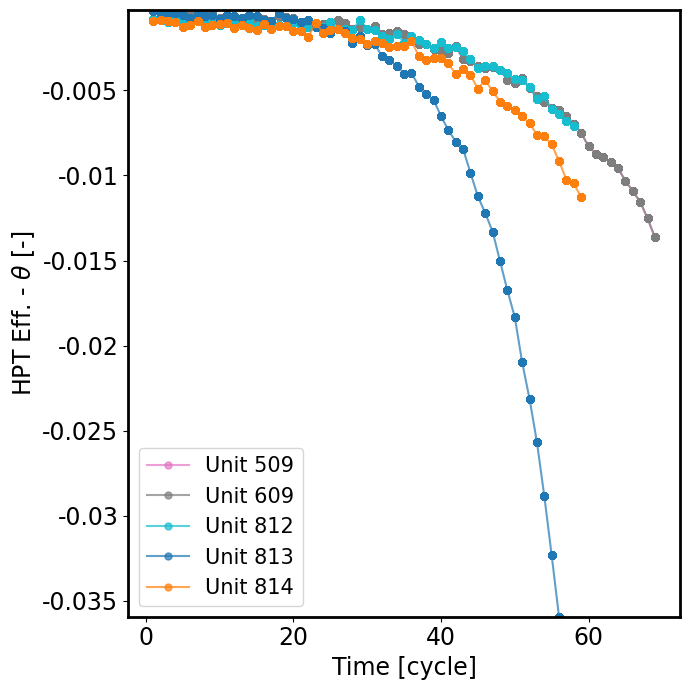

In [28]:
units = [509,609,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_eff_mod'], [r'HPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

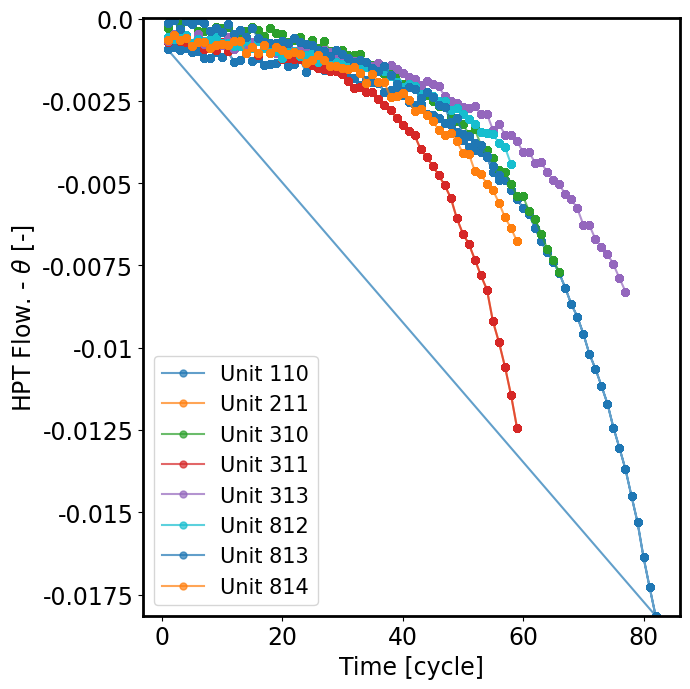

In [29]:
units = [110,211,310,311,313,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['HPT_flow_mod'], [r'HPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

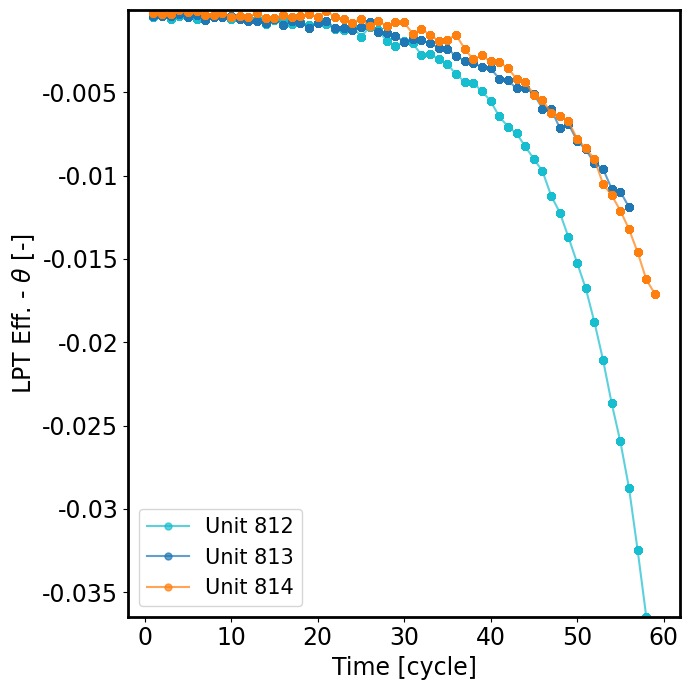

In [30]:
units = [812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_eff_mod'], [r'LPT Eff. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)

<Figure size 900x600 with 0 Axes>

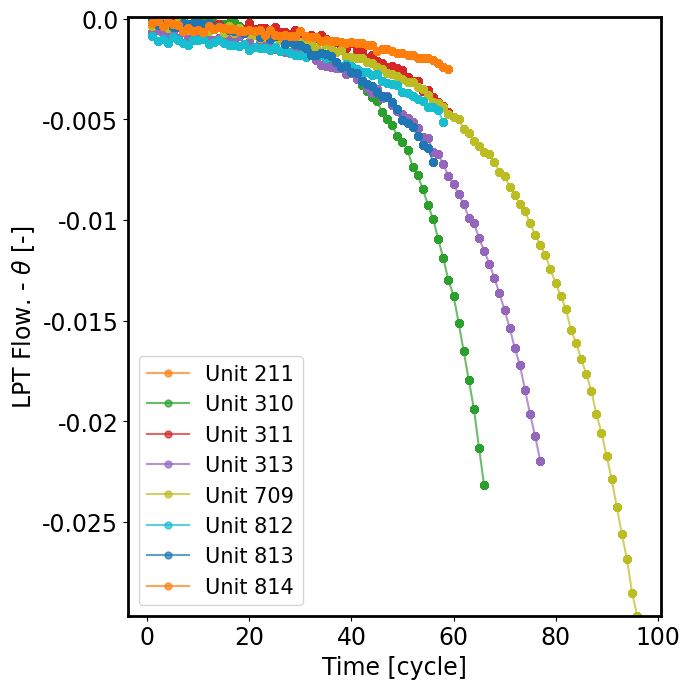

In [31]:
units = [211,310,311,313,709,812,813,814] 
plot_df_color_per_unit(df_test[df_test.unit.isin(units)], ['LPT_flow_mod'], [r'LPT Flow. - $\theta$ [-]'], color_dic_unit, option='cycle', theta=True)